In [ ]:
!pip install emoji
!pip install contractions
!pip install nltk
!pip install nlpaug


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, GlobalAveragePooling1D, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import time
import emoji
import re
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import MultiHeadAttention
from tqdm import tqdm

# Download necessary NLTK resources
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
data = pd.read_csv('Sentiment_Data.csv', encoding='latin1')

In [ ]:
data.dropna(subset=['Tweet'], inplace=True)


In [ ]:
data.drop_duplicates(subset='Tweet', inplace=True)


In [ ]:
# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r"@[A-Za-z0-9]*", "", text)

    # Remove hashtags
    text = re.sub(r'#', '', text)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Replace newlines and &amp;
    text = re.sub('\n', " ", text)
    text = re.sub("&amp;", " and ", text)

    # Remove excess whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Demojize emojis
    text = emoji.demojize(text, delimiters=("", ""))

    # Expand contractions
    text = contractions.fix(text)

    # Handle negations
    tokens = word_tokenize(text)
    tokens = [contractions.fix(word) for word in tokens]
    text = ' '.join(tokens)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)

    return text

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

tqdm.pandas(desc="Cleaning data")

# Apply preprocessing with progress bar
data['Cleaned_Tweet'] = data['Tweet'].progress_apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cleaning data: 100%|██████████| 451279/451279 [06:52<00:00, 1094.66it/s]


In [ ]:
# Label encoding
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['Tweet'], data['Sentiment'], test_size=0.2, random_state=42)


In [ ]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Determine max length dynamically
maxlen = min(690, int(np.percentile([len(seq) for seq in X_train_seq], 95)))
print(maxlen)
# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen, truncating='post', padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen, truncating='post', padding='post')

46


In [ ]:
# Positional encoding function
def get_positional_encoding(max_seq_length, d_model):
    pos = np.arange(max_seq_length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Model building function
def build_transformer_model(vocab_size, embed_dim, num_heads, dff, maxlen):
    input = Input(shape=(maxlen,))
    x = Embedding(vocab_size, embed_dim)(input)  # Embedding layer
    positional_encoding = get_positional_encoding(maxlen, embed_dim)
    x = Add()([x, positional_encoding])  # Adding positional encoding

    # Add multiple transformer blocks
    for _ in range(2):  # Number of transformer blocks
        x = TransformerBlock(128, 8, 512, 0.1)(x, training=False) # Provide training argument
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.15)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(len(np.unique(y_train)), activation='softmax')(x)
    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
# Define hyperparameters
vocab_size = 10000
embed_dim = 128
num_heads = 8
dff = 512

# Build and compile the model
model = build_transformer_model(vocab_size, embed_dim, num_heads, dff, maxlen)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer_block_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer_block_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test))


Epoch 1/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 151s 12ms/step - accuracy: 0.6126 - loss: 1.0564 - val_accuracy: 0.7660 - val_loss: 0.6559
Epoch 2/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 173s 10ms/step - accuracy: 0.7866 - loss: 0.6180 - val_accuracy: 0.7923 - val_loss: 0.5970
Epoch 3/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 144s 10ms/step - accuracy: 0.8021 - loss: 0.5796 - val_accuracy: 0.8053 - val_loss: 0.5730
Epoch 4/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 145s 11ms/step - accuracy: 0.8089 - loss: 0.5614 - val_accuracy: 0.8069 - val_loss: 0.5654
Epoch 5/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 138s 10ms/step - accuracy: 0.8137 - loss: 0.5492 - val_accuracy: 0.8045 - val_loss: 0.5677


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f"Test Accuracy: {accuracy:.4f}")

2821/2821 - 9s - 3ms/step - accuracy: 0.8045 - loss: 0.5677
Test Accuracy: 0.8045


In [ ]:
# Predictions for multiclass classification
y_pred_probs = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred_probs, axis=-1)

2821/2821 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


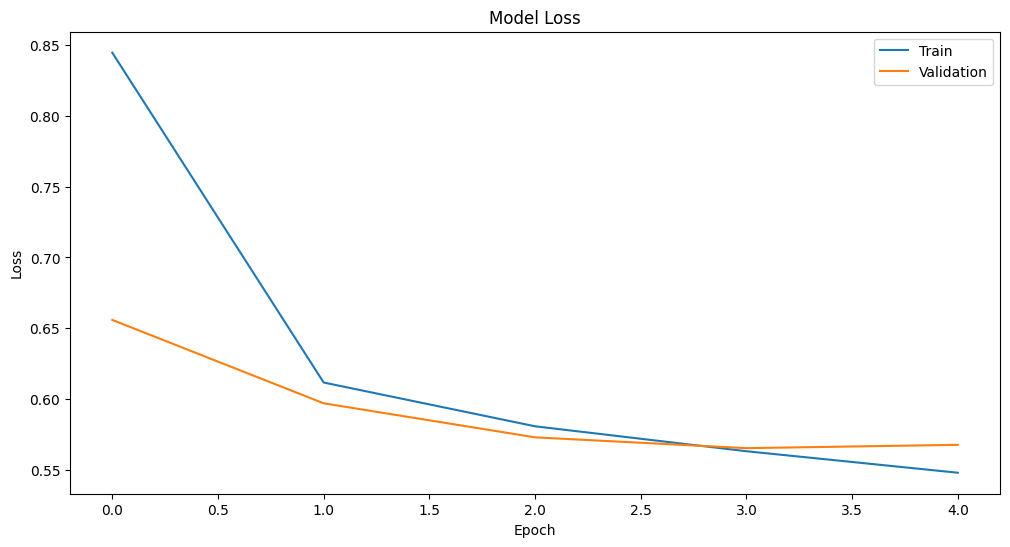

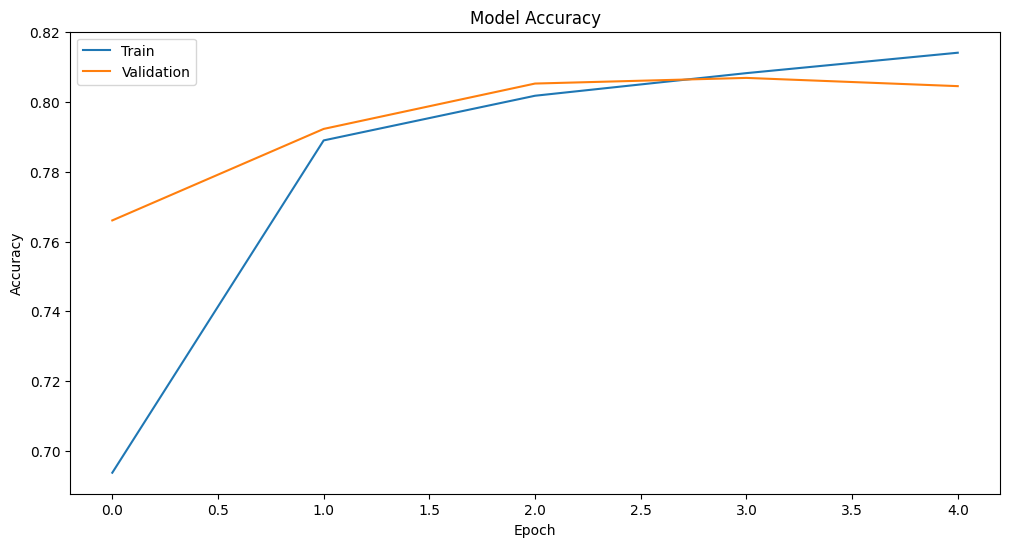

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


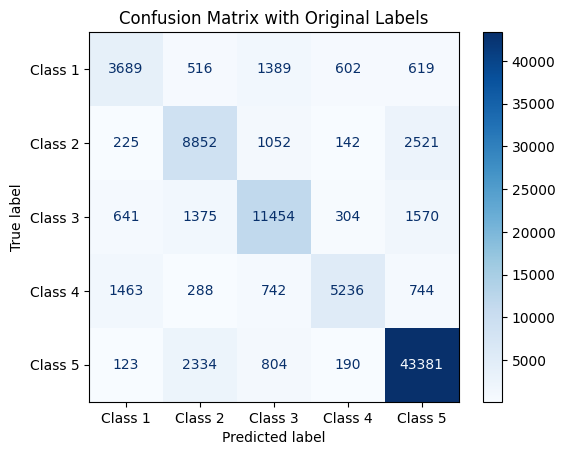

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define the class names (replace with your actual class names)
class_names = ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"] # Example class names, replace as needed

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with the original labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Original Labels")
plt.show()

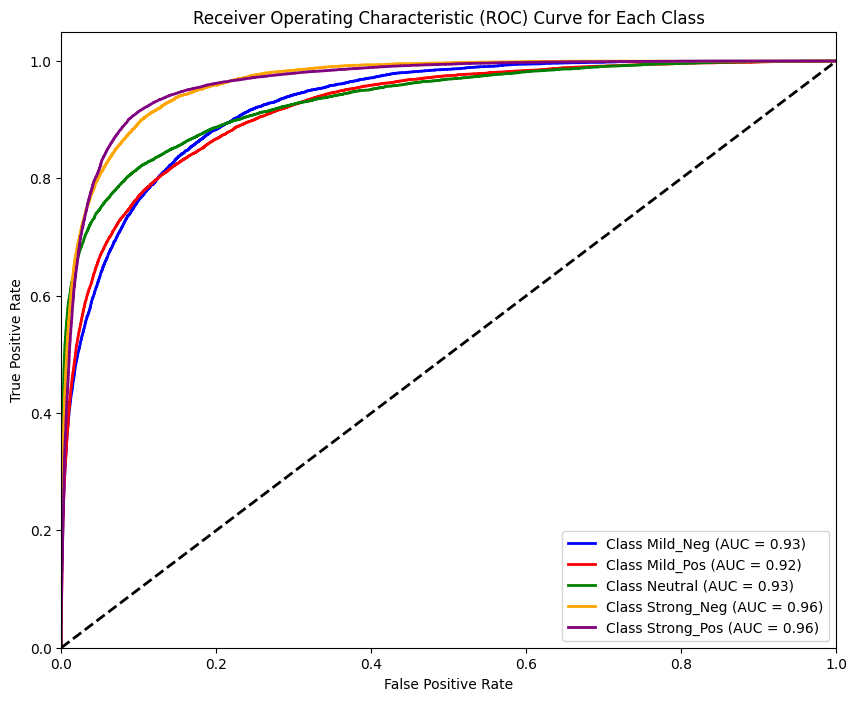

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert true labels to one-hot encoding
y_test_onehot = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
n_classes = y_test_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


Tunning 1


In [ ]:
import nlpaug.augmenter.word as naw

# Initialize augmenters
synonym_aug = naw.SynonymAug(aug_src='wordnet')
contextual_aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

# Function to apply multiple augmentations
def augment_text(text, augmenters):
    for aug in augmenters:
        text = aug.augment(text)
    return text

In [ ]:
augmenters = [synonym_aug, contextual_aug]


In [ ]:
tqdm.pandas(desc="Augmenting data")
data['Augmented_Tweet'] = data['Tweet'][:100].progress_apply(lambda x: augment_text(x, augmenters))

Augmenting data: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


In [ ]:
# Concatenate original and augmented data
cd = pd.concat([data[['Tweet', 'Sentiment']], data[['Augmented_Tweet', 'Sentiment']].rename(columns={'Augmented_Tweet': 'Tweet'})])
cd.reset_index(drop=True, inplace=True)

In [ ]:
cd['Tweet'].isnull().any()


True

In [ ]:
cd.dropna(subset=['Tweet'], inplace=True)


In [ ]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(cd['Tweet'][255779:])

In [ ]:
sequences = tokenizer.texts_to_sequences(cd['Tweet'][255779:])


In [ ]:
maxlen = 68
padded_sequences = pad_sequences(sequences, maxlen=maxlen, truncating='post', padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, cd['Sentiment'][255779:], test_size=0.2, random_state=42)


In [ ]:
# Define hyperparameters
vocab_size = 10000
embed_dim = 128 #256
num_heads = 8
dff = 512

# Build and compile the model
model = build_transformer_model(vocab_size, embed_dim, num_heads, dff, maxlen)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer_block_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer_block_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 86s 14ms/step - accuracy: 0.5692 - loss: 1.1948 - val_accuracy: 0.7558 - val_loss: 0.6934
Epoch 2/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - accuracy: 0.7638 - loss: 0.6756 - val_accuracy: 0.7873 - val_loss: 0.6153
Epoch 3/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.7960 - loss: 0.5998 - val_accuracy: 0.8032 - val_loss: 0.5825
Epoch 4/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.8071 - loss: 0.5711 - val_accuracy: 0.7822 - val_loss: 0.6195
Epoch 5/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - accuracy: 0.8116 - loss: 0.5577 - val_accuracy: 0.8063 - val_loss: 0.5706
Epoch 6/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.8153 - loss: 0.5457 - val_accuracy: 0.7970 - val_loss: 0.5893
Epoch 7/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 88s 16ms/step - accuracy: 0.8197 - loss: 0.5351 - val_accuracy: 0.8065 - val_loss: 0.5646
Epoch 8/10
4890/4890 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8256 -

Tunning 2


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data['Tweet'], data['Sentiment'], test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (361023,), y_train shape: (361023,)
X_test shape: (90256,), y_test shape: (90256,)


In [ ]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(f"X_train_seq length: {len(X_train_seq)}, X_test_seq length: {len(X_test_seq)}")

X_train_seq length: 361023, X_test_seq length: 90256


In [ ]:
# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen, truncating='post', padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen, truncating='post', padding='post')

print(f"X_train_padded shape: {X_train_padded.shape}, X_test_padded shape: {X_test_padded.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train_padded shape: (361023, 68), X_test_padded shape: (90256, 68)
y_train shape: (361023,), y_test shape: (90256,)


In [ ]:
# Ensure all lengths match
assert len(X_train) == len(y_train), "Mismatch between X_train and y_train lengths"
assert len(X_test) == len(y_test), "Mismatch between X_test and y_test lengths"
assert len(X_train_seq) == len(y_train), "Mismatch between X_train_seq and y_train lengths"
assert len(X_test_seq) == len(y_test), "Mismatch between X_test_seq and y_test lengths"
assert X_train_padded.shape[0] == y_train.shape[0], "Mismatch between X_train_padded and y_train shapes"
assert X_test_padded.shape[0] == y_test.shape[0], "Mismatch between X_test_padded and y_test shapes"

Transformer Build


In [ ]:
from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, Embedding, Input, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

class TransformersBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, l2_reg=0.01):
        super(TransformersBlock, self).__init__() # If the error persists, there might be a deeper issue with class definitions
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu', kernel_regularizer=l2(l2_reg)),
            Dense(d_model, kernel_regularizer=l2(l2_reg))
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)  # Multi-head attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Add & Norm
        ffn_output = self.ffn(out1)  # Feed Forward Network
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Norm
        return out2

# ... (rest of the code remains the same)

def get_positional_encoding(max_seq_length, d_model):
    pos = np.arange(max_seq_length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def build_tm(vocab_size, embed_dim, num_heads, dff, maxlen, dropout_rate_transformer, dropout_rate_dense, l2_reg=0.01):
    input = Input(shape=(maxlen,))
    x = Embedding(vocab_size, embed_dim, embeddings_regularizer=l2(l2_reg))(input)  # Embedding layer with regularization
    positional_encoding = get_positional_encoding(maxlen, embed_dim)
    x = Add()([x, positional_encoding])  # Adding positional encoding

    # Add multiple transformer blocks
    for _ in range(2):  # Number of transformer blocks
        x = TransformersBlock(embed_dim, num_heads, dff, dropout_rate_transformer, l2_reg)(x, training=True) # Pass 'training' argument here
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate_dense)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate_dense)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    output = Dense(len(np.unique(y_train)), activation='softmax')(x)
    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
# Update hyperparameters
embed_dim = 128
num_heads = 8
dff = 512
dropout_rate_transformer = 0.15
dropout_rate_dense = 0.1
vocab_size=10000

In [ ]:
model4 = build_tm(vocab_size, embed_dim, num_heads, dff, maxlen, dropout_rate_transformer, dropout_rate_dense, l2_reg=0.01) # Call build_tm instead of build_transformer_model
model4.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historoi = model4.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test))


Epoch 1/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 192s 16ms/step - accuracy: 0.5163 - loss: 1.8312 - val_accuracy: 0.5189 - val_loss: 1.3364
Epoch 2/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 171s 14ms/step - accuracy: 0.5175 - loss: 1.3376 - val_accuracy: 0.5189 - val_loss: 1.3358
Epoch 3/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 210s 14ms/step - accuracy: 0.5177 - loss: 1.3371 - val_accuracy: 0.5189 - val_loss: 1.3361
Epoch 4/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 195s 14ms/step - accuracy: 0.5181 - loss: 1.3380 - val_accuracy: 0.5189 - val_loss: 1.3358
Epoch 5/5
11282/11282 ━━━━━━━━━━━━━━━━━━━━ 200s 14ms/step - accuracy: 0.5174 - loss: 1.3382 - val_accuracy: 0.5189 - val_loss: 1.3359


In [ ]:
loss, accuracy = model4.evaluate(X_test_padded, y_test, verbose=2) # Change model3 to model4
print(f"Test Accuracy: {accuracy:.4f}")

2821/2821 - 14s - 5ms/step - accuracy: 0.5189 - loss: 1.3359
Test Accuracy: 0.5189


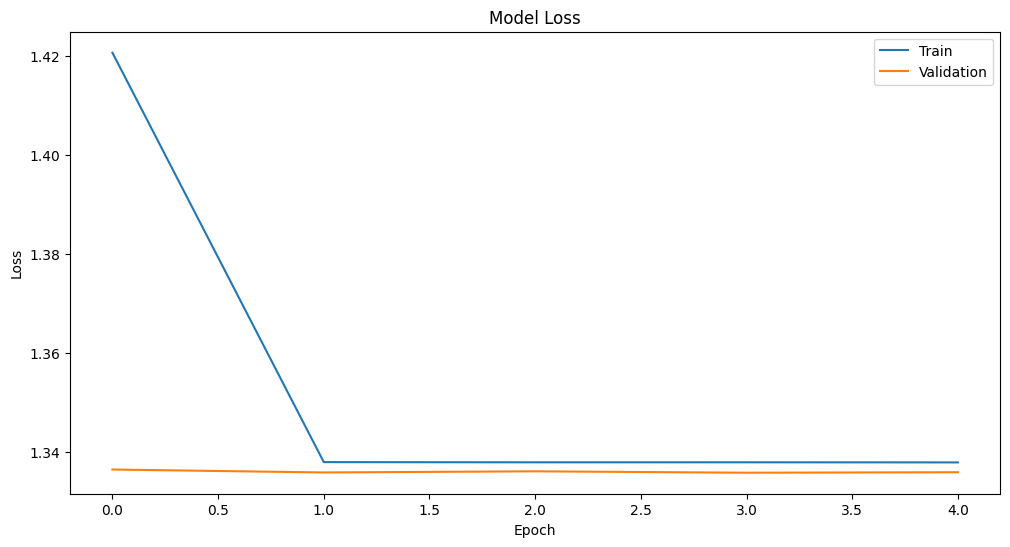

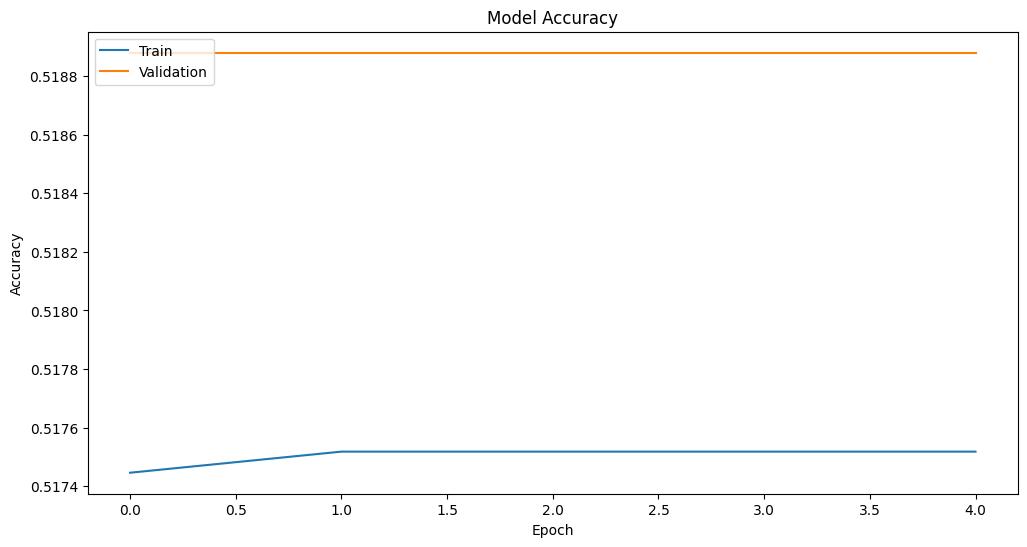

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(historoi.history['loss'])
plt.plot(historoi.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(historoi.history['accuracy'])
plt.plot(historoi.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model.save('sentiment_model.h5')


In [ ]:
import pickle
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
